    Node - implements a single node of a decision tree
    DecisionTree - implements a single decision tree
    RandomForest - implements our ensemble algorithm

In [15]:
import numpy as np
from collections import Counter

In [2]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

Let’s implement the decision tree classifier next. It will contain a bunch of methods, all of which are discussed below:

    __init__() - the constructor, holds values for min_samples_split and max_depth. These are hyperparameters. The first one is used to specify a minimum number of samples required to split a node, and the second one specifies a maximum depth of a tree. Both are used in recursive functions as exit conditions
    _entropy(s)- calculates the impurity of an input vector s
    _information_gain(parent, left_child, right_child) calculates the information gain value of a split between a parent and two children
    _best_split(X, y) function calculates the best splitting parameters for input features X and a target variable y. It does so by iterating over every column in X and every threshold value in every column to find the optimal split using information gain
    _build(X, y, depth) function recursively builds a decision tree until stopping criteria is met (hyperparameters in the constructor)
    fit(X, y) function calls the _build() function and stores the built tree to the constructor
    _predict(x) function traverses the tree to classify a single instance
    predict(X) function applies the _predict() function to every instance in matrix X.

Yes, it’s a lot, but you should already feel comfortable with this. Here’s the code snippet for a single decision tree:

In [3]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [11]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue
    
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = RandomForest()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [17]:
print(preds)

[1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0]


In [18]:
print(y_test)

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [2]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [6]:
!curl -o filetest.csv "https://download.wetransfer.com/eugv/1abee5c5c88282b3b6fdbef58251ca6f20220527101010/482b3f784792c0d16d8c01dfb4f16074ce6caa7a/filetest.csv?token=eyJhbGciOiJIUzI1NiJ9.eyJpYXQiOjE2NTM2NDY3NTksImV4cCI6MTY1MzY0NzM1OSwidW5pcXVlIjoiMWFiZWU1YzVjODgyODJiM2I2ZmRiZWY1ODI1MWNhNmYyMDIyMDUyNzEwMTAxMCIsImZpbGVuYW1lIjoiZmlsZXRlc3QuY3N2Iiwid2F5YmlsbF91cmwiOiJodHRwOi8vc3Rvcm0taW50ZXJuYWwuc2VydmljZS5ldS13ZXN0LTEud2V0cmFuc2Zlci5uZXQvYXBpL3dheWJpbGxzP3NpZ25lZF93YXliaWxsX2lkPWV5SmZjbUZwYkhNaU9uc2liV1Z6YzJGblpTSTZJa0pCYUhOTGQyZFpOazFHVWtGUlFUMGlMQ0psZUhBaU9pSXlNREl5TFRBMUxUSTNWREV4T2pJNU9qRTVMakF3TUZvaUxDSndkWElpT2lKM1lYbGlhV3hzWDJsa0luMTktLTU5NWJlYjBlMjFiODc2YWYwNDYzZWQ4NzRlOTA1OTk1NDUwMTYyOGNiNGVhN2E4MWQyNDEyMjE3ZmFlYzkzZDgiLCJmaW5nZXJwcmludCI6IjQ4MmIzZjc4NDc5MmMwZDE2ZDhjMDFkZmI0ZjE2MDc0Y2U2Y2FhN2EiLCJjYWxsYmFjayI6IntcImZvcm1kYXRhXCI6e1wiYWN0aW9uXCI6XCJodHRwOi8vZnJvbnRlbmQuc2VydmljZS5ldS13ZXN0LTEud2V0cmFuc2Zlci5uZXQvd2ViaG9va3MvYmFja2VuZFwifSxcImZvcm1cIjp7XCJ0cmFuc2Zlcl9pZFwiOlwiMWFiZWU1YzVjODgyODJiM2I2ZmRiZWY1ODI1MWNhNmYyMDIyMDUyNzEwMTAxMFwiLFwiZG93bmxvYWRfaWRcIjoxNTM2NTUwOTcwMH19In0.risBefZi2gkDvI6VX5P_RaEVCk45mp4clPlOqrnbAxo&cf=y" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/100.0" -H "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8" -H "Accept-Language: en-US,en;q=0.5" -H "Accept-Encoding: gzip, deflate, br" -H "Referer: https://wetransfer.com/" -H "Connection: keep-alive" -H "Cookie: _wt_snowplowid.0497=be4c2c38-2632-4d37-abc5-e2d1bd7c11f0.1653389068.4.1653646756.1653639109.a6166e2b-b293-4343-b110-5d07107f24a3; auth_session_uuid=f6e8d581-05df-47f0-8aca-ee11d8a30b4e; _gcl_au=1.1.1969794957.1653389073; wt_privacy="%"7B"%"22v"%"22"%"3A"%"223"%"3A20190527"%"22"%"2C"%"22f"%"22"%"3A1"%"2C"%"22a"%"22"%"3A1"%"2C"%"22t"%"22"%"3A1"%"7D; wt_first_visit=1653389073204; wt_tandc=20190527"%"3A1; sp=9487e778-8918-42e5-a19f-ae1729d875bf; _ga=GA1.2.1872555267.1653389076; _fbp=fb.1.1653389076840.2138156562; _clck=ztt6u8|1|f1t|0; _rdt_uuid=1653389099220.71a6ff0c-221f-4861-840a-96c1a182d6df; _au_1d=AU1D-0100-001653389100-781U7WMO-CTUP; wt_takeover=5"%"2F24"%"2F2022"%"2C0; cto_bundle=9AgvYV91N0tsNjU0MFRHRmZ3bmlFZ3ZEN0h5WmZmJTJCM21CckRMaElhTXlNZE1pVWROR2tTYzVETkZ2cXF2cGZyUDVwQ2g3aTlVZFl2QzVJU0VGaGxwZW41TXdLQWlaWU5DRzFTJTJCTUJoTGVycXRFMlVLQXd0ZWpEVEVPRzVVdTVPSGt0aTlhRTVDbXNZdUhsb3V5T3JDU2xvNm53JTNEJTNE; wt_ttype=4; wt_sent=3; wt_downloaded=14; _au_last_seen_apn=1653538558826; _au_last_seen_ttd=1653538558826; _au_last_seen_pub=1653538558826; _au_last_seen_adx=1653538558826; _au_last_seen_goo=1653538558826; _au_last_seen_taboola=1653538558826; _au_last_seen_bees=1653538558826; _au_last_seen_smart=1653538558826; _au_last_seen_ado=1653538558826; _au_last_seen_impr=1653538558826; _au_last_seen_openx=1653540335450; _au_last_seen_rub=1653540335450; _au_last_seen_mediamath=1653540335450; _au_last_seen_unruly=1653540335450; _au_last_seen_son=1653540335450; _au_last_seen_ppnt=1653540335450; _gid=GA1.2.1850572312.1653634743; _clsk=18ip2la|1653646530798|3|0|h.clarity.ms/collect; _wt_snowplowses.0497=*; _tt_enable_cookie=1; _ttp=23f1e28b-c59a-45cd-b14b-e9988c7fdfa3; _uetsid=7d1d5460dd8a11ec955367a8d539f00b; _uetvid=7ffd6ee0db4e11ecaec4c36c5ad633ed" -H "Upgrade-Insecure-Requests: 1" -H "Sec-Fetch-Dest: document" -H "Sec-Fetch-Mode: navigate" -H "Sec-Fetch-Site: same-site" -H "Sec-Fetch-User: ?1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5585k  100 5585k    0     0  5585k      0  0:00:01  0:00:01 --:--:-- 5585k


In [42]:
df_train = pd.read_csv("file.csv",  
                  names=['Numbers','Labels'])

In [8]:
df_train

,Numbers,Labels
0,2,1.0
1,3,1.0
2,5,1.0
3,7,1.0
4,11,1.0
...,...,...
15485859,15485858,0.0
15485860,15485859,0.0
15485861,15485860,0.0
15485862,15485861,0.0


In [43]:
df_test = pd.read_csv("filetest.csv",  
                  names=['Numbers','Labels'])

In [10]:
df_test

,Numbers,Labels
0,15485867,1.0
1,15485917,1.0
2,15485927,1.0
3,15485933,1.0
4,15485941,1.0
...,...,...
514258,16000124,0.0
514259,16000125,0.0
514260,16000126,0.0
514261,16000127,0.0


In [44]:
df_train.drop(df_train.index[2000000:-1],inplace=True)

In [45]:
df_train.drop(index=df_train.index[-1], 
        axis=0, 
        inplace=True)

In [16]:

x_train = np.asarray(df_train['Numbers']).astype(np.int32)

#y_train = np.asarray(df_train['Labels']).astype(np.int32)
y_train = np.asarray(df_train['Labels']).astype(np.int32)


In [17]:
x_train=x_train.reshape(-1,1)
#val_x_train = np.asarray(x_val["Numbers"]).astype(np.float32)

#val_y_train = np.asarray(x_val["Labels"]).astype(np.float32)
x_train

array([[      2],
       [      3],
       [      5],
       ...,
       [1084601],
       [1084602],
       [1084603]], dtype=int32)

In [19]:
x_test = np.asarray(df_test['Numbers']).astype(np.int32)

#y_train = np.asarray(df_train['Labels']).astype(np.int32)
y_test = np.asarray(df_test['Labels']).astype(np.int32)


In [20]:
x_test=x_test.reshape(-1,1)
#val_x_train = np.asarray(x_val["Numbers"]).astype(np.float32)

#val_y_train = np.asarray(x_val["Labels"]).astype(np.float32)
x_test

array([[15485867],
       [15485917],
       [15485927],
       ...,
       [16000126],
       [16000127],
       [16000128]], dtype=int32)

In [22]:
sk_model = RandomForestClassifier()
sk_model.fit(x_train, y_train)

RandomForestClassifier()

In [23]:
sk_preds = sk_model.predict(x_test)

In [25]:
from sklearn import metrics

In [29]:
metrics.accuracy_score(y_test, sk_preds)

0.06054489628847496

In [30]:
print(sk_preds)

[1 1 1 ... 1 1 1]


In [31]:
print(y_test)

[1 1 1 ... 0 0 0]


In [35]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_decision_forests-0.2.6-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.8 MB)
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 5.8 MB 60.0 MB/s 
     |████████████████████████████████| 1.6 MB 60.1 MB/s 
     |████████████████████████████████| 438 kB 60.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall:

In [36]:
import tensorflow_decision_forests as tfdf

In [47]:


# Load a dataset in a Pandas dataframe.
#train_df = pd.read_csv("project/train.csv")
#test_df = pd.read_csv("project/test.csv")

# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_train, label="Labels")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_test, label="Labels")

# Train a Random Forest model.
model = tfdf.keras.RandomForestModel(max_depth=2)
model.fit(train_ds)

# Summary of the model structure.
model.summary()

# Evaluate the model.
model.evaluate(test_ds)

# Export the model to a SavedModel.
model.save("project/model")


Use /tmp/tmp90pdow9e as temporary training directory
Reading training dataset...


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


Training dataset read in 0:00:04.424175. Found 2000000 examples.
Training model...
Model trained in 0:01:14.455231
Compiling model...
Model compiled.
Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (1):
	Numbers

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  1.000000 ################
    2. "Numbers"  0.000000 

Variable Importance: NUM_AS_ROOT:
    1. "Numbers" 300.000000 

Variable Importance: NUM_NODES:
    1. "Numbers" 300.000000 

Variable Importance: SUM_SCORE:
    1. "Numbers" 326796809.792519 



Winner take all: true
Out-of-bag evaluation: accuracy:0.957698 logloss:1.52472
Number of trees: 300
Total number of nodes: 900

Number of nodes by tree:

INFO:tensorflow:Assets written to: project/model/assets


INFO:tensorflow:Assets written to: project/model/assets


In [51]:
model.predict([4])

1/1 [==============================] - 0s 87ms/step


array([[0.]], dtype=float32)

Streaming output truncated to the last 5000 lines.
49.74% complete. Finished with number 4998
49.75% complete. Finished with number 4999
49.76% complete. Finished with number 5000
49.77% complete. Finished with number 5001
49.78% complete. Finished with number 5002
49.79% complete. Finished with number 5003
49.8% complete. Finished with number 5004
49.81% complete. Finished with number 5005
49.82% complete. Finished with number 5006
49.83% complete. Finished with number 5007
49.84% complete. Finished with number 5008
49.85% complete. Finished with number 5009
49.86% complete. Finished with number 5010
49.87% complete. Finished with number 5011
49.88% complete. Finished with number 5012
49.89% complete. Finished with number 5013
49.9% complete. Finished with number 5014
49.91% complete. Finished with number 5015
49.92% complete. Finished with number 5016
49.93% complete. Finished with number 5017
49.94% complete. Finished with number 5018
49.95% complete. Finished with number 5019
49.96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in log


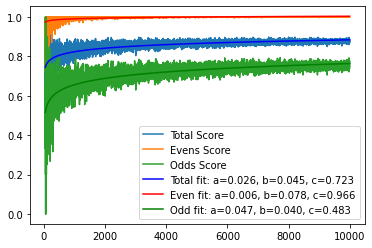

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

total_numbers_considered = []
total_scores = []
even_scores = []
odd_scores = []
fifty_percent_scores = []

def run(total_number):
	total_numbers_considered.append(total_number)
	number = []
	digits = []
	primes = []
	max_number = total_number
	max_length = len(str(max_number))

	def getPrimes(N):
		primes_to_check = []
		primes_to_return = []

		for n in range(2, N+1):

			prime = True

			for i in primes_to_check:

				if n%i==0:

					prime = False

			if(prime):
				primes_to_return.append(1)
			else:
				primes_to_return.append(0)

			if (n**2 < N and prime):
				primes_to_check.append(n)

		return primes_to_return


	primes = getPrimes(max_number)

	for i in range(2, max_number+1):

		numbers = []
		for d in str(i):
			numbers.append(int(d))

		if len(str(i)) < max_length:
			for neg_one in range(max_length-len(str(i))):
				numbers.insert(0,-1)
		digits.append(numbers)
		number.append(i)

	new_digits = []

	for digit in range(len(digits[0])):
		new_digit_column = []
		for num in range(len(number)):
			new_digit_column.append(digits[num][digit])
		new_digits.append(new_digit_column)

	dictionary = {"Number": number, "Prime": primes}
	for digit_column in range(len(new_digits)):
		dictionary[str(10**(len(new_digits)-digit_column-1))] = new_digits[digit_column]

	primes_df = pd.DataFrame(dictionary)
	features = primes_df.drop("Prime", axis=1).columns.values
	primes_df = shuffle(primes_df)

	train = primes_df[0: round(max_number*.8)]
	test = primes_df[round(max_number*.8)+1: max_number]
	test_evens = test[test["Number"]%2==0]
	test_odds = test[test["Number"]%2==1]

	features = primes_df.drop("Prime", axis=1).columns.values
	clf = RandomForestClassifier(max_depth=2, random_state=0)
	clf.fit(train[features], train["Prime"])

	total_score = clf.score(test[features], test["Prime"])
	total_scores.append(total_score)

	even_score = clf.score(test_evens[features], test_evens["Prime"])
	even_scores.append(even_score)

	odd_score = clf.score(test_odds[features], test_odds["Prime"])
	odd_scores.append(odd_score)

max_run = 9999
min_run = 50

for i in range(min_run, max_run):
	print(str(round((i-min_run)/(max_run-min_run)*100,2))+"% complete. Finished with number "+str(i-1))
	run(i)

def fit_func(x, a, b, c):
	return a * np.log(b * x) + c

total_numbers_considered = np.array(total_numbers_considered)
total_scores = np.array(total_scores)
even_scores = np.array(even_scores)
odd_scores = np.array(odd_scores)

popt_total, pcov_total = curve_fit(fit_func, total_numbers_considered, total_scores)
popt_even, pcov_even = curve_fit(fit_func, total_numbers_considered, even_scores)
popt_odd, pcov_odd = curve_fit(fit_func, total_numbers_considered, odd_scores)

plt.plot(total_numbers_considered, total_scores, label="Total Score")
plt.plot(total_numbers_considered, even_scores, label="Evens Score")
plt.plot(total_numbers_considered, odd_scores, label="Odds Score")
plt.plot(total_numbers_considered, fit_func(total_numbers_considered, *popt_total), 'b-', label='Total fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_total))
plt.plot(total_numbers_considered, fit_func(total_numbers_considered, *popt_even), 'r-', label='Even fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_even))
plt.plot(total_numbers_considered, fit_func(total_numbers_considered, *popt_odd), 'g-', label='Odd fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_odd))

plt.legend(loc=4)
plt.show()

NameError: ignored